In [100]:
import numpy as np
import pandas as pd
import librosa
import json
import os
from tqdm import tqdm

In [101]:
import os
import pandas as pd
import json

# Set your dataset folder path
folder_path = r"public_dataset"  # Use your actual path

# Create lists to store file paths and labels
files = []
cough_scores = []
timestamps = []

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.wav'):
        # Get the WAV file path
        wav_path = os.path.join(folder_path, file_name)
        files.append(wav_path)
        
        # Get corresponding JSON file
        json_name = file_name.replace('.wav', '.json')
        json_path = os.path.join(folder_path, json_name)
        
        # Read the label from JSON
        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                data = json.load(f)
                cough_scores.append(float(data['cough_detected']))
                timestamps.append(data['datetime'])
        else:
            cough_scores.append(0.0)  # Default if no JSON
            timestamps.append('unknown')

# Create a simple DataFrame
df = pd.DataFrame({
    'file_path': files,
    'cough_confidence': cough_scores,
    "timestamp" : timestamps
})

# Display basic info
print(f"Total files: {len(df)}")
df.sample(2)

Total files: 27550


,file_path,cough_confidence,timestamp
11087,public_dataset\66b2cf07-cf97-4512-ba63-7c539e1...,0.8962,2020-05-12T21:57:29.563101+00:00
8988,public_dataset\53d71017-5f13-439b-b538-11b2101...,0.8623,2020-05-10T00:22:26.887773+00:00


## Feature Extraction

In [78]:
def extract_feature(file_path, n_mfcc = 13):
    try: 
        audio, sr = librosa.load(file_path)

        # getting the MFCC features
        mfcc = librosa.feature.mfcc(y = audio, n_mfcc = 13, sr = sr)

        # Calculate statistics for each MFCC coefficient
        features = []
        for i in range(n_mfcc):
            features.append(np.mean(mfcc[i]))   # Mean
            features.append(np.std(mfcc[i]))    # Standard deviation
            features.append(np.median(mfcc[i])) # Median
        
        return np.array(features)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [79]:
from tqdm import tqdm
def extract_features_memory_efficient(df, batch_size=1000):
    """
    Extract features in batches to save memory.
    """
    all_features = []
    file_paths = df['file_path'].tolist()
    
    # Process in batches
    for i in range(0, len(file_paths), batch_size):
        batch = file_paths[i:i+batch_size]
        batch_features = []
        
        print(f"Processing batch {i//batch_size + 1}/{(len(file_paths)+batch_size-1)//batch_size}")
        
        for file_path in batch:
            features = extract_feature(file_path)
            if features is not None:
                batch_features.append(features)
        
        all_features.extend(batch_features)
    
    return np.array(all_features)

X = extract_features_memory_efficient(df, batch_size = 1000)


Processing batch 1/28
Processing batch 2/28
Processing batch 3/28
Processing batch 4/28
Processing batch 5/28
Processing batch 6/28
Processing batch 7/28
Processing batch 8/28
Processing batch 9/28
Processing batch 10/28
Processing batch 11/28
Processing batch 12/28
Processing batch 13/28
Processing batch 14/28
Processing batch 15/28
Processing batch 16/28
Processing batch 17/28
Processing batch 18/28
Processing batch 19/28
Processing batch 20/28
Processing batch 21/28
Processing batch 22/28
Processing batch 23/28
Processing batch 24/28
Processing batch 25/28
Processing batch 26/28
Processing batch 27/28
Processing batch 28/28


In [132]:
X

array([[-6.20258301e+02,  1.15819954e+02, -6.32759399e+02, ...,
        -8.59991550e+00,  1.27234869e+01, -5.20205545e+00],
       [-5.63337891e+02,  1.40359909e+02, -6.17042236e+02, ...,
         1.63018417e+00,  5.95483398e+00,  0.00000000e+00],
       [-7.36402893e+02,  1.04955772e+02, -7.74696411e+02, ...,
        -7.70698965e-01,  5.97670364e+00, -9.39301074e-01],
       ...,
       [-6.80959351e+02,  1.15093575e+02, -7.21424500e+02, ...,
         3.41879189e-01,  6.85482979e+00,  0.00000000e+00],
       [-2.65393616e+02,  1.41069519e+02, -2.28041992e+02, ...,
         4.65520525e+00,  1.07360497e+01,  4.21475315e+00],
       [-4.43157318e+02,  1.59387131e+02, -5.48171753e+02, ...,
        -1.00166047e+00,  7.25175810e+00,  0.00000000e+00]],
      shape=(27550, 39), dtype=float32)

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
# Creating the label
y = (df["cough_confidence"] >= 0.5).astype(int).values

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

## Random Forest Classifier

In [104]:
pipe_ran_for = Pipeline([ 
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier( random_state = 42 ))
])
pipe_ran_for.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(random_state=42))])

In [105]:
pipe_ran_for.score(X_test, y_test)

0.9117967332123412

In [106]:
y_preds = pipe_ran_for.predict(X_test)
y_preds

array([1, 0, 0, ..., 1, 1, 0], shape=(5510,))

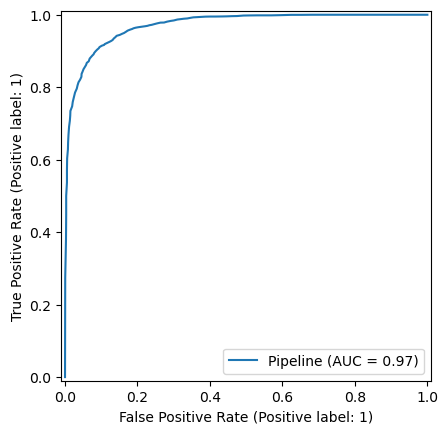

In [107]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(pipe_ran_for, X_test, y_test)
plt.show();

In [108]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[1597  284]
 [ 202 3427]]


In [110]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1881
           1       0.92      0.94      0.93      3629

    accuracy                           0.91      5510
   macro avg       0.91      0.90      0.90      5510
weighted avg       0.91      0.91      0.91      5510



## Logistic Regression

In [111]:
pipe_log_reg = Pipeline([ 
    ("scaler", StandardScaler()),
    ("model", LogisticRegression( random_state = 42 ))
])
pipe_log_reg.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(random_state=42))])

In [112]:
pipe_log_reg.score(X_test, y_test)

0.9027223230490018

In [113]:
y_preds = pipe_log_reg.predict(X_test)
y_preds

array([1, 0, 0, ..., 1, 1, 0], shape=(5510,))

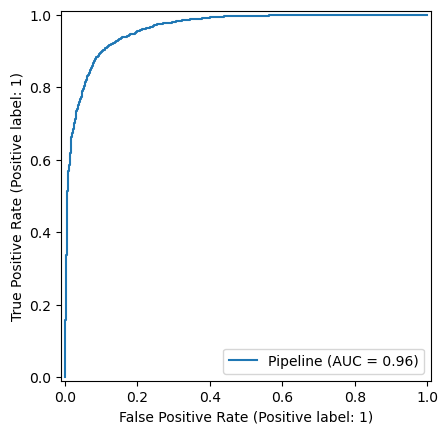

In [114]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(pipe_log_reg, X_test, y_test)
plt.show()

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[1557  324]
 [ 212 3417]]


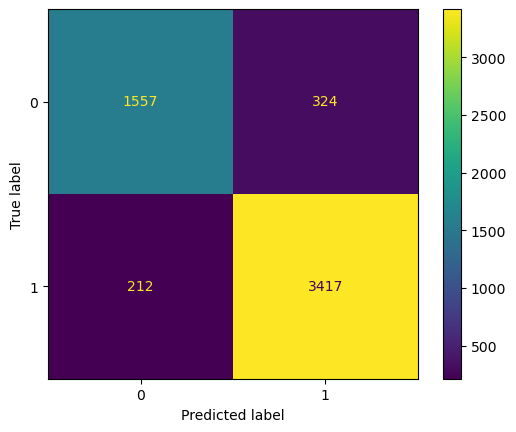

In [116]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();

In [117]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1881
           1       0.91      0.94      0.93      3629

    accuracy                           0.90      5510
   macro avg       0.90      0.88      0.89      5510
weighted avg       0.90      0.90      0.90      5510



In [119]:
from scipy.stats import randint, uniform
ran_for_dist = {
    "n_estimators" : np.arange(10, 2001, 50),
    "max_depth" : [None, 5, 10, 15, 20, 30],
    "min_samples_split" : np.arange(2, 21, 2), 
    "min_samples_leaf" : np.arange(1, 11, 2),
    "max_features": ['sqrt', 'log2', None, 0.2, 0.5, 0.8],    
};

ran_for_dist_light = {
    "n_estimators": randint(50, 401),
    "max_depth": [None, 8, 12, 16, 24],
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 6),
    "max_features": ['sqrt', 'log2', 0.3, 0.5]
}

In [120]:
# from sklearn.model_selection import RandomizedSearchCV
# rs_ran_for = RandomizedSearchCV(
#     RandomForestClassifier( random_state = 42),
#     param_distributions = ran_for_dist,
#     cv = 5, 
#     n_iter = 150,
#     verbose = 2, 
#     n_jobs=-1,
#     random_state = 42,
#     refit = True,
#     scoring = "accuracy")
# rs_ran_for.fit(X_train, y_train);

In [122]:
rs = RandomizedSearchCV(
    LogisticRegression( random_state = 42),
    param_distributions=ran_for_dist_light,
    n_iter=40,   
    cv=3,         
    scoring='accuracy',
    n_jobs=-1,    
    random_state=42,
    verbose=2,
    refit=True
)

rs.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'max_depth': [None, 8, 12, 16, 24],
                                        'max_features': ['sqrt', 'log2', 0.3,
                                                         0.5],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002423BA7A210>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002423BA7A350>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024235A6D160>},
                   random_state=42, scoring='accuracy', verbose=2)

In [123]:
print("best params:", rs.best_params_)

best params: {'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 332}


In [128]:
final_rf = RandomForestClassifier(
    n_estimators=332,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.3,
    random_state=42,
    n_jobs=-1
)

final_rf.fit(X_train, y_train)

RandomForestClassifier(max_features=0.3, n_estimators=332, n_jobs=-1,
                       random_state=42)

In [129]:
final_rf.score(X_test, y_test)

0.9123411978221415

In [130]:
y_preds = final_rf.predict(X_test)
y_preds

array([1, 0, 0, ..., 1, 1, 0], shape=(5510,))

In [131]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1881
           1       0.92      0.95      0.93      3629

    accuracy                           0.91      5510
   macro avg       0.91      0.90      0.90      5510
weighted avg       0.91      0.91      0.91      5510

